##1.Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Embedding,LSTM,Dense,Flatten,Bidirectional,GRU,TimeDistributed,Add,Attention,Concatenate
from tensorflow.keras import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import shutil
from datetime import datetime
from dateutil import tz
import json
import math
from tqdm.notebook import tqdm
from collections import Counter
import numpy as np
from os.path import exists
import matplotlib.pyplot as plt


##2.Data

>### a. Data import

In [ ]:
!wget http://files.srl.inf.ethz.ch/data/js_dataset.tar.gz

--2020-07-17 06:49:51--  http://files.srl.inf.ethz.ch/data/js_dataset.tar.gz
Resolving files.srl.inf.ethz.ch (files.srl.inf.ethz.ch)... 129.132.85.35
Connecting to files.srl.inf.ethz.ch (files.srl.inf.ethz.ch)|129.132.85.35|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.sri.inf.ethz.ch/data/js_dataset.tar.gz [following]
--2020-07-17 06:49:52--  https://files.sri.inf.ethz.ch/data/js_dataset.tar.gz
Resolving files.sri.inf.ethz.ch (files.sri.inf.ethz.ch)... 129.132.85.35
Connecting to files.sri.inf.ethz.ch (files.sri.inf.ethz.ch)|129.132.85.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2632133476 (2.5G) [application/x-gzip]
Saving to: ‘js_dataset.tar.gz’

js_dataset.tar.gz   100%[===================>]   2.45G  24.6MB/s    in 1m 50s  

2020-07-17 06:51:43 (22.8 MB/s) - ‘js_dataset.tar.gz’ saved [2632133476/2632133476]



>### b. Unpacking

>>#### i. Dataset

In [ ]:
print(datetime.now(tz=tz.gettz('Asia/Kolkata')))
shutil.unpack_archive("/content/js_dataset.tar.gz")
print(datetime.now(tz=tz.gettz('Asia/Kolkata')))

2020-07-17 12:21:44.206025+05:30
2020-07-17 12:25:56.769602+05:30


In [ ]:
eval_file_path="/content/programs_eval.json"

>>#### ii. GloVe embeddings and Dictionaries

In [ ]:
shutil.unpack_archive('/content/inputData.zip')

In [ ]:
NT_dict_path='/content/Non_Terminal_Dictionary.txt'
T_dict_path='/content/Terminal_Dictionary.txt'
glove_path='/content/glove.6B.50d.txt'

>>#### ii. Models

In [ ]:
shutil.unpack_archive('/content/models.zip')

In [ ]:
nt_emb_train_path="/content/nt_emb_train"
model1_path="/content/model1"
model2_n_path="/content/model2_n"
model2_t_path="/content/model2_t"
model3_path="/content/model3"

>### c. Splitting the JSON training file into smaller files

The file "programs_training.json" contains parsed ASTs in JSON format for the files in programs_training.txt. One program is present per line with a total of 10K(`tot_lines`) programs. We have divided this file into 5(`num_files`) smaller files with each file containing 20 K programs.

In [ ]:
tot_lines=100000
num_files=5

In [ ]:
org_train_file= open("/content/programs_training.json",encoding="latin-1")
org_txt_file=open("/content/programs_training.txt")

for i in tqdm(range(num_files)):
  file_id=str(i+1)
  
  write_train_file=open("/content/programs_training_"+file_id+".json",'a')
  write_txt_file=open("/content/programs_training_"+file_id+".txt",'a')
    
  for _ in range(int(tot_lines/num_files)):
    write_train_file.write(org_train_file.readline())
    write_txt_file.write(org_txt_file.readline())

  write_train_file.close()
  write_txt_file.close()
  # if i == 0: 
  #   break

org_train_file.close()
org_txt_file.close()

>### e. Creating a dataset of serialized truncated ASTs

In [ ]:
node_count=50 #The number of nodes considered per AST 
embed_dim=50 #The embedding dimension of each Terminal/Non-Terminal
t_occ_thres=5e-5 #The minimum frequency of occurence that makes a terminal eligible to be included in the terminal list. 
unknown_t="unknown" #All the terminals ineligible to be a part of the terminal list are replaced by this token.

In [ ]:
#Each node in the serialized truncated ASTs (LCRS representation) is represented as an object of class Node.
class Node:
    def __init__(self,key,left=None,children=None): 
        self.left = left
        self.right = None
        self.val = key + ":"
        self.children = children

In [ ]:
#This function converts a AST to LCRS (binary) representation.
def json2LCRS(json_tree): 
  #create a list of all NT nodes

  node_list=list()
  for node_dict in json_tree[:-1]:
      if("children" in node_dict.keys()):
        node_list.append(Node(node_dict["type"],children=node_dict["children"]))
      elif("value" in node_dict.keys()):
        node_list.append(Node(node_dict["type"],left=node_dict["value"]))
      else:
        node_list.append(Node(node_dict["type"],left=node_dict["type"]+".value"))
  
  #create a LCRS tree with root as "root"

  q=list()
  root=node_list[0]
  q.append(root)
  while(len(q)>0):
      node=q.pop(0)
      child_list=[node_list[id] for id in node.children]
      node.left=child_list[0]
      for i in range(len(child_list)-1):
          child_list[i].right=child_list[i+1]
      for child in child_list:
          if(child.children!=None):
              q.append(child)

  #Update NT nodes with structural information
  for node in node_list:
      lc=node.left
      rs=node.right

      if(type(lc)==str):
          node.val+="T"
      else:
          node.val+="N"

      if(rs==None):
          node.val+="A"
      else:
          node.val+="P"
    
  return root

In [ ]:
#This function creats a sequetial (pre order) representation of the tree.
def preorder(node):

  stack=list()
  pre_lst=list()
  stack.append(node)
  while(len(stack)>0):

    if(len(pre_lst)>=node_count):
      break

    node=stack.pop()
      
    lc=node.left
    rs=node.right
    
    lval=""
    rval=""
    
    if(type(lc)==str):
        lval=lc
    else:
        lval=lc.val
        
    if(rs==None):
        rval="NULL"
    else:
        rval=rs.val
    
    pre_lst.append([node.val,lval,rval])

    if(type(node.left)==Node):
      stack.append(node.left)

    if(type(node.right)==Node):
      stack.append(node.right)
    
  return pre_lst

Data is a three dimensional dataset. Each row represents a particular program. The row is made up of a list of string triplets. The triplets consist of: 

1.   The parent Non Terminal
2.   Left child (Can be a Non Terminal or a Terminal)
3.   Right sibling (If present)





In [ ]:
def jsonstrs_to_data(json_strs,node_count = 50 ):
  data=np.empty(shape=(len(json_strs),node_count,3),dtype=object)
  i=0
  for json_str in json_strs:
    lcrs_root=json2LCRS(json.loads(json_str))
    pre_lst=preorder(lcrs_root)
    if(len(pre_lst)>=node_count):
      for j in range(node_count):
        data[i,j,0]=pre_lst[j][0]
        data[i,j,1]=pre_lst[j][1]
        data[i,j,2]=pre_lst[j][2]
      i+=1
  data=data[:i]
  data.shape
  return data

>### e. Numeric tokenisation of the dataset

In [ ]:
#This function creates a list of Non Terminals and a list of Terminals from the data
def create_lists(data):
  nt_list=list()
  t_list=list()

  for i in range(data.shape[0]):
    for j in range(node_count):
      
      tag_info=data[i][j][0][-2:]
      nt_list.append(data[i][j][0])
      
      if(tag_info=="NA"):
        nt_list.append(data[i][j][1])
      elif(tag_info=="NP"):
        nt_list.append(data[i][j][1])
        nt_list.append(data[i][j][2])
      elif(tag_info=="TA"):
        t_list.append(data[i][j][1])
      elif(tag_info=="TP"):
        t_list.append(data[i][j][1])
        nt_list.append(data[i][j][2])

  #NT tokenisation
  return list(set(nt_list)) , list(set(t_list))
 

In [ ]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('/content/glove.6B.'+str(embed_dim)+'d.txt','r',encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs
f.close()

In [ ]:
if(exists(NT_dict_path) and exists(T_dict_path)):

  print("Dictionary found. Loading it.")
  #Loading the dictionary

  unique_nt_dict = {}
  f = open(NT_dict_path)
  for line in f:
      values = line.split(' ')
      word = values[0]
      coefs = int(values[1][:-1])
      unique_nt_dict[word] = coefs
  f.close()

  unique_t_dict = {}
  f = open(T_dict_path)
  for line in f:
      values = line.split(' ')
      word = values[0]
      coefs = int(values[1][:-1])
      unique_t_dict[word] = coefs
  f.close()

  nt_list_length=len(unique_nt_dict.keys())
  t_list_length=len(unique_t_dict.keys())

else:
  nt_list = []
  t_list = []

  print("Dictionary not found. Creating it.")
  #Extracting unique non terminals and terminals
  for i in tqdm(range(1,6)):  
    with open("/content/programs_training_"+ str(i) + ".json",encoding="latin-1") as train_file:
      json_strs=train_file.read().split('\n')[:-1]
      data = jsonstrs_to_data(json_strs)
      temp_nt_list , temp_t_list= create_lists(data)

      nt_list += temp_nt_list
      nt_list = list(set(nt_list))
      t_list += temp_t_list
      t_list = list(set(t_list))
  
  #removing terminals not in GloVe embedding
  glove_key_list=list(embeddings_index.keys())
  t_list_red=list()
  for t in tqdm(global_t_list):
    if t in glove_key_list:
      t_list_red.append(t)


  #Creating the dictionaries
  nt_list_length=len(nt_list)

  dict_values_nt=list(range(nt_list_length))

  unique_nt_dict={key:value for key,value in zip(nt_list,dict_values_nt)}
  unique_nt_dict["PAD"]=0

  t_list_length=len(t_list_red)+1

  dict_values_t=list(range(1,t_list_length))

  unique_t_dict={key:value for key,value in zip(t_list_red,dict_values_t)}

  #Saving the dictionaries
  nt_file=open(nt_dict_path,'w')
  for k,v in unique_nt_dict.items():
    nt_file.write(k+" "+str(v)+'\n')
  nt_file.close()

  t_file=open(t_dict_path,'w')
  for k,v in unique_t_dict.items():
    t_file.write(k+" "+str(v)+'\n')
  t_file.close()

Dictionary found. Loading it.


In [ ]:
#This functions maps each element of the data into there respective numeric tokens
def create_token(data):
  unk=0
  norm=0
  data_tkns=np.empty_like(data)

  for i in range(data.shape[0]):
    for j in range(node_count):
      tag_info=data[i][j][0][-2:]
      data_tkns[i,j,0]=unique_nt_dict[data[i,j,0]]
      
      if(tag_info=="NA"):
        data_tkns[i,j,1]=unique_nt_dict[data[i,j,1]]
        data_tkns[i,j,2]=unique_nt_dict["PAD"]
      elif(tag_info=="NP"):
        data_tkns[i,j,1]=unique_nt_dict[data[i,j,1]]
        data_tkns[i,j,2]=unique_nt_dict[data[i,j,2]]
      elif(tag_info=="TA"):
        if(data[i,j,1] in unique_t_dict.keys()):
          norm+=1
          data_tkns[i,j,1]=unique_t_dict[data[i,j,1]]
        else:
          unk+=1
          data_tkns[i,j,1]=unique_t_dict[unknown_t]
        data_tkns[i,j,2]=unique_nt_dict["PAD"]
      elif(tag_info=="TP"):
        if(data[i,j,1] in unique_t_dict.keys()):
          norm+=1
          data_tkns[i,j,1]=unique_t_dict[data[i,j,1]]
        else:
          unk+=1
          data_tkns[i,j,1]=unique_t_dict[unknown_t]
        data_tkns[i,j,2]=unique_nt_dict[data[i,j,2]]
      
  return data_tkns

##3.Model

>### a. Embeddings

In [ ]:
es=EarlyStopping(monitor="val_loss",mode="min",patience=5,restore_best_weights=True) #Early stopping criteria during training

>>#### i. Non terminal embeddings training model

In [ ]:
#Model for creating the non terminal embedding vector
def create_nt_emb_train():
  nt_input = Input(shape=(node_count-1,),name="nt_emb_train_input")

  nt_embedding=Embedding(input_dim=nt_list_length,output_dim=embed_dim,name="nt_emb")
  nt_embedding_out=nt_embedding(nt_input)

  bd_lstm =Bidirectional(LSTM(100),name="nt_emb_train_bd_lstm")
  bd_lstm_out=bd_lstm(nt_embedding_out)

  dense=Dense(nt_list_length,activation="softmax",name="nt_emb_train_dense")
  dense_out=dense(bd_lstm_out)

  nt_emb_train=Model(nt_input,dense_out,name="nt_emb_train")

  nt_emb_train.compile(
    optimizer="Adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )
  
  return nt_emb_train

In [ ]:
if(exists(nt_emb_train_path)):

  print("Model found. Loading it.")
  nt_emb_train=load_model(nt_emb_train_path)
  nt_emb_train.summary()
  
else:

  print("Model not found. Creating it.")
  #Defining model structure
  
  nt_emb_train=create_nt_emb_train()
  nt_emb_train.summary()
  
  
  #Training file by file

  loss_list=list()
  accuracy_list=list()
  val_loss_list=list()
  val_accuracy_list=list()

  for i in range(num_files):

    file_name="/content/programs_training_"+ str(i+1) + ".json" 
    print ("Training model with file: "+file_name) 
    with open(file_name,encoding="latin-1") as train_file:
      json_strs=train_file.read().split('\n')[:-1]
      data = jsonstrs_to_data(json_strs)
      data_tkns = create_token(data)

    X_ntemb=data_tkns[:,:node_count-1,0]
    y_ntemb=data_tkns[:,node_count-1,0]
    del data_tkns
    del data
    y_ntemb_cat=to_categorical(y_ntemb,num_classes=nt_list_length)
    nt_emb_train_history = nt_emb_train.fit(X_ntemb.astype(int),y_ntemb_cat.astype(float),epochs=32,validation_split=0.2,callbacks=[es])

    #Creating loss and accuracy list
    loss_list+=nt_emb_train_history.history["loss"]
    accuracy_list+=nt_emb_train_history.history["accuracy"]
    val_loss_list+=nt_emb_train_history.history["val_loss"]
    val_accuracy_list+=nt_emb_train_history.history["val_accuracy"]
    # if i == 1: 
    #   break

  # Saving the model
  nt_emb_train.save(nt_emb_train_path)

  #Displaying loss graph
  plt.plot(loss_list)
  plt.plot(val_loss_list)
  plt.title('nt_emb_train loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper right')
  plt.show()
  plt.savefig("model_loss_nt_emb_train.png")

  #Displaying accuracy graph
  plt.plot(accuracy_list)
  plt.plot(val_accuracy_list)
  plt.title('nt_emb_train accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.show()
  plt.savefig("model_accuracy_nt_emb_train.png")


Model found. Loading it.
Model: "nt_emb_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
nt_emb_train_input (InputLay [(None, 49)]              0         
_________________________________________________________________
nt_emb (Embedding)           (None, 49, 50)            4850      
_________________________________________________________________
nt_emb_train_bd_lstm (Bidire (None, 200)               120800    
_________________________________________________________________
nt_emb_train_dense (Dense)   (None, 97)                19497     
Total params: 145,147
Trainable params: 145,147
Non-trainable params: 0
_________________________________________________________________


>>#### ii. Non terminal embeddings prediction model

In [ ]:
#The following code creates the embedding vectors for each non terminal using the nt_emb_train model
nt_emb_predict=Model(nt_emb_train.input,nt_emb_train.get_layer(name="nt_emb").output)
num_rows=int(math.ceil(nt_list_length/(node_count-1)))
nt_ind=np.array(list(range(num_rows*(node_count-1)))).astype(float)
nt_ind[nt_ind>=nt_list_length]=0.
nt_ind=nt_ind.reshape((num_rows,(node_count-1)))
non_term_embeddings_list=nt_emb_predict.predict(nt_ind)
non_term_embeddings=np.concatenate(non_term_embeddings_list)[:nt_list_length]
non_term_embeddings.shape

(97, 50)

>### b. Non Terminal and Terminal model training

We now define 4 new models.


1.   `model1` is used to predict the parent Non terminal (first element of the triplet).
2.  `model2_n` and `model2_t` is used to predict the left child (second element of the triplet).
>*   `model2_n` is used for scenarios where the second child is a Non Terminal.
>*   `model2_t` is used for scenarios where the second child is a Terminal.

3. `model3` is used to predict the right sibling (third element of the triplet).



In [ ]:
def create_model(model_name,input_dim,output_dim):
  model_input = Input(shape=(input_dim,embed_dim),name=model_name+"_input")

  lstm =LSTM(100,return_state=True,name=model_name+"_lstm")
  lstm_out,state_h,state_c=lstm(model_input)

  att=Attention(name=model_name+"_attention")
  att_out=att([lstm_out,state_h])

  add=Add(name=model_name+"_add")
  add_out=add([lstm_out,att_out])

  dense=Dense(output_dim,activation="softmax",name=model_name+"_dense")
  dense_out=dense(add_out)

  model=Model(model_input,dense_out,name=model_name)

  model.compile(
    optimizer="Adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )
  
  return model

In [ ]:
#The following function sums up the embeddings of the triplets into a single embedding vector for each triplet
#This embedding vector is used for training model 1.
def generate_combined_embeddings(data):
  data_emb=np.empty((data.shape[0],data.shape[1],embed_dim))

  p=0
  q=0

  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      
      tag_info=data[i][j][0][-2:]
      emb_1=non_term_embeddings[unique_nt_dict[data[i,j,0]]]
      
      if(tag_info=="NA"):
        emb_2=non_term_embeddings[unique_nt_dict[data[i,j,1]]]
        emb_3=np.zeros_like(emb_1)
      elif(tag_info=="NP"):
        emb_2=non_term_embeddings[unique_nt_dict[data[i,j,1]]]
        emb_3=non_term_embeddings[unique_nt_dict[data[i,j,2]]]
      elif(tag_info=="TA"):
        if(data[i,j,1] in unique_t_dict.keys()):
          emb_2=embeddings_index[data[i,j,1]]
          p+=1
        else:
          emb_2=embeddings_index[unknown_t]
          q+=1
        emb_3=np.zeros_like(emb_1)
      elif(tag_info=="TP"):
        if(data[i,j,1] in unique_t_dict.keys()):
          emb_2=embeddings_index[data[i,j,1]]
          p+=1
        else:
          emb_2=embeddings_index[unknown_t]
          q+=1
        emb_3=non_term_embeddings[unique_nt_dict[data[i,j,2]]]

      data_emb[i,j,:]=emb_1+emb_2+emb_3
  return data_emb

In [ ]:
#The following function extracts the data from data_emb to creating training data for each of the model.
def create23_data(data):
  X_model2_n=np.empty((data.shape[0],node_count,embed_dim))
  X_model2_t=np.empty_like(X_model2_n)
  X_model3=np.empty_like(X_model2_n)

  y_model2_n=list()
  y_model2_t=list()
  y_model3=list()

  nk2=0
  tk2=0
  nk3=0
  for j in tqdm(range(data.shape[0])):

      parent=data[j,node_count-1,0]
      lc=data[j,node_count-1,1]
      rs=data[j,node_count-1,2]

      row=np.empty((1,node_count,embed_dim))
      row[:,:node_count-1,:]=X_model1[j]
      row[:,node_count-1,:]=non_term_embeddings[unique_nt_dict[parent]]
      tag=parent[-2:]
      
      if(tag=="NA"):
        X_model2_n[nk2]=row
        nk2+=1
        if(lc in unique_nt_dict.keys()):
          y_model2_n.append(unique_nt_dict[lc])
        else:
          y_model2_n.append(unique_nt_dict[list(unique_nt_dict.keys())[0]])

      elif(tag=="NP"):
        X_model2_n[nk2]=row
        nk2+=1
        y_model2_n.append(unique_nt_dict[lc])

        if(rs!="NULL"):
          row[:,node_count-1,:]+=non_term_embeddings[unique_nt_dict[lc]]
          X_model3[nk3]=row
          nk3+=1
          y_model3.append(unique_nt_dict[rs])

      elif(tag=="TA"):
        
        X_model2_t[tk2]=row
        tk2+=1
        if(lc not in unique_t_dict.keys()):
          lc=unknown_t  
        y_model2_t.append(unique_t_dict[lc])
        
      elif(tag=="TP"):
        
        X_model2_t[tk2]=row
        tk2+=1
        if(lc not in unique_t_dict.keys()):
          lc=unknown_t  
        y_model2_t.append(unique_t_dict[lc])

        if(rs!="NULL"):
          row[:,node_count-1,:]+=embeddings_index[lc]
          X_model3[nk3]=row
          nk3+=1
          y_model3.append(unique_nt_dict[rs])

  X_model2_n=X_model2_n[:nk2]
  X_model2_t=X_model2_n[:tk2]
  X_model3=X_model3[:nk3]

  y_model2_n=np.array(y_model2_n)
  y_model2_t=np.array(y_model2_t)
  y_model3=np.array(y_model3)

  y_model2_n_cat=to_categorical(y_model2_n,num_classes=nt_list_length)
  y_model2_t_cat=to_categorical(y_model2_t,num_classes=t_list_length)
  y_model3_cat=to_categorical(y_model3,num_classes=nt_list_length)

  return (X_model2_n,y_model2_n_cat,X_model2_t,y_model2_t_cat,X_model3,y_model3_cat)

The following functions are used to record the statistics generated during the model training.

In [ ]:
def save_model_history(history, loss_list , accuracy_list, val_loss_list, val_accuracy_list): 
  loss_list+=history.history["loss"]
  accuracy_list+=history.history["accuracy"]
  val_loss_list+=history.history["val_loss"]
  val_accuracy_list+=history.history["val_accuracy"]
  return loss_list , accuracy_list, val_loss_list, val_accuracy_list

In [ ]:
loss_list1=list()
accuracy_list1=list()
val_loss_list1=list()
val_accuracy1=list()

loss_list2=list()
accuracy_list2=list()
val_loss_list2=list()
val_accuracy2=list()


loss_list3=list()
accuracy_list3=list()
val_loss_list3=list()
val_accuracy3=list()


loss_list4=list()
accuracy_list4=list()
val_loss_list4=list()
val_accuracy4=list()

In [ ]:
 def display_loss_graph(model, loss_list , accuracy_list, val_loss_list, val_accuracy_list ):
    plt.plot(loss_list)
    plt.plot(val_loss_list)
    plt.title('nt_emb_train loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    plt.savefig(model + "_loss.png")

    #Displaying accuracy graph
    plt.plot(accuracy_list)
    plt.plot(val_accuracy_list)
    plt.title('nt_emb_train accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    plt.savefig(model + "_accuracy.png")

In [ ]:
if(exists(model1_path) and exists(model2_n_path) and exists(model2_t_path) and exists(model3_path)):
 
  print("Models found. Loading them.")
  model1=load_model(model1_path)
  model2_n=load_model(model2_n_path)
  model2_t=load_model(model2_t_path)
  model3=load_model(model3_path)
 
else:
 
  print("Models not found. Creating them.")
  #Defining models' structure
  
  model1=create_model("model1",node_count-1,nt_list_length)
  model2_n=create_model("model2_n",node_count,nt_list_length)
  model2_t=create_model("model2_t",node_count,t_list_length)
  model3=create_model("model3",node_count,nt_list_length)
 
  for i in range(2 , num_files):  
    
    file_name="/content/programs_training_"+ str(i+1) + ".json" 
    print ("Training model with file: "+file_name) 
    with open(file_name,encoding="latin-1") as train_file:
    
      json_strs=train_file.read().split('\n')[:-1]
      data = jsonstrs_to_data(json_strs)
    
    #Model 1 data
    
    #Creating X
    data_X=data[:,:node_count-1,:]
    X_model1= generate_combined_embeddings(data_X)
 
    #Creating y
    data_tkns = create_token(data)
    y_model1=data_tkns[:,node_count-1,0]
    y_model1_cat=to_categorical(y_model1,num_classes=nt_list_length)
 
    #Model 2 and 3 data
    (X_model2_n,y_model2_n_cat,X_model2_t,y_model2_t_cat,X_model3,y_model3_cat)=create23_data(data)
 
    #training file by file 
    h1 = model1.fit(X_model1.astype(float),y_model1_cat.astype(float),epochs=32,validation_split=0.2,callbacks=[es])
    h2_n = model2_n.fit(X_model2_n.astype(float),y_model2_n_cat.astype(float),epochs=32,validation_split=0.2,callbacks=[es])
    h2_t = model2_t.fit(X_model2_t.astype(float),y_model2_t_cat.astype(float),epochs=32,validation_split=0.2,callbacks=[es])
    h3 = model3.fit(X_model3.astype(float),y_model3_cat.astype(float),epochs=32,validation_split=0.2,callbacks=[es])
 
    #Creating loss and accuracy list
    loss_list1 , accuracy_list1, val_loss_list1, val_accuracy1 = save_model_history(h1, loss_list1 , accuracy_list1, val_loss_list1, val_accuracy1)
    loss_list2_n , accuracy_list2_n, val_loss_list2_n, val_accuracy2_n = save_model_history(h2_n, loss_list2_n , accuracy_list2_n, val_loss_list2_n, val_accuracy2_n)
    loss_list2_t , accuracy_list2_t, val_loss_list2_t, val_accuracy2_t = save_model_history(h2_t, loss_list2_t , accuracy_list2_t, val_loss_list2_t, val_accuracy2_t)
    loss_list3 , accuracy_list3, val_loss_list3, val_accuracy3 = save_model_history(h3, loss_list3 , accuracy_list3, val_loss_list3, val_accuracy3)
  
  print("Saving the models.")
  #Saving the models
  model1.save(model1_path)
  model2_n.save(model2_n_path)
  model2_t.save(model2_t_path)
  model3.save(model3_path)

Models found. Loading them.


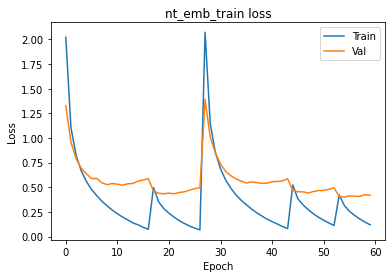

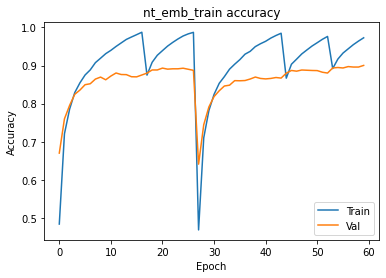

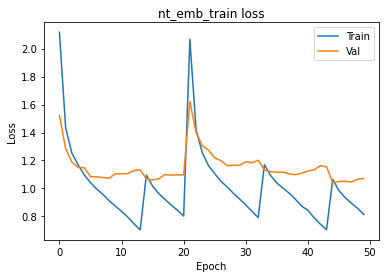

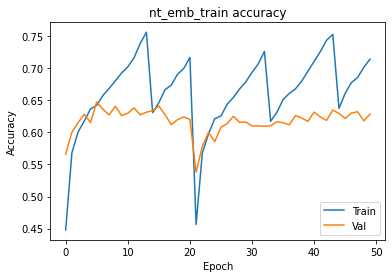

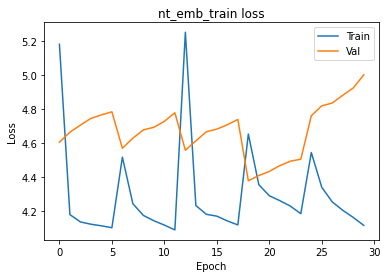

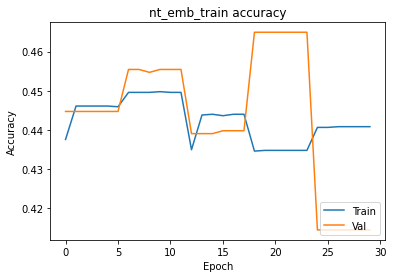

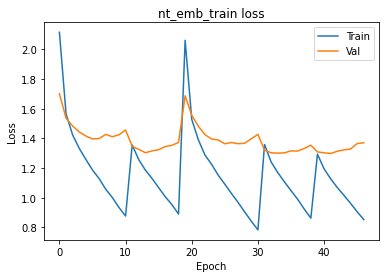

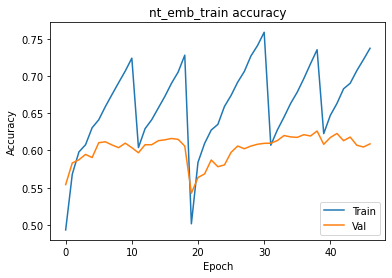

<Figure size 432x288 with 0 Axes>

In [ ]:
display_loss_graph("model1", loss_list1 , accuracy_list1, val_loss_list1, val_accuracy1 )
display_loss_graph("model2", loss_list2 , accuracy_list2, val_loss_list2, val_accuracy2 )
display_loss_graph("model3", loss_list3 , accuracy_list3, val_loss_list3, val_accuracy3 )
display_loss_graph("model4", loss_list4 , accuracy_list4, val_loss_list4, val_accuracy4 )

##4.Ensemble

In [ ]:
#reversing dictionaries to get the terminal/non-terminal from tokens
nt_dict_rev={v:k for k,v in unique_nt_dict.items()}
t_dict_rev={v:k for k,v in unique_t_dict.items()}

In [ ]:
#creating data for evaluation
with open(eval_file_path,encoding="latin-1") as train_file:
    json_strs=train_file.read(int(2e7)).split('\n')[:-1]
    data = jsonstrs_to_data(json_strs)

>### a. Model 1 (Parent Node)

In [ ]:
#Creating X
data_X=data[:,:node_count-1,:]
X_model1= generate_combined_embeddings(data_X)

#Creating y
data_tkns = create_token(data)
y_model1=data_tkns[:,node_count-1,0]
y_model1_cat=to_categorical(y_model1,num_classes=nt_list_length)

In [ ]:
#predicting parent tokens
parent_tkns_cat=model1.predict(X_model1.astype(float))
parent_tkns_pred=np.argmax(parent_tkns_cat,axis=1)
parent_nt_pred=[nt_dict_rev[tkns] for tkns in parent_tkns_pred]
print("Accuracy of model1 is:",sum((y_model1 == parent_tkns_pred))/len(y_model1))

Accuracy of model1 is: 0.8644859813084113


>### b. Model 2 (Left Child)

In [ ]:
for i in range(data.shape[0]):
  data[i,embed_dim-1,0]=parent_nt_pred[i]

In [ ]:
(X_model2_n,y_model2_n_cat,X_model2_t,y_model2_t_cat,X_model3,y_model3_cat)=create23_data(data)

In [ ]:
#Predicting lc Non Terminal
lc_nt_tkns_cat=model2_n.predict(X_model2_n.astype(float))
lc_nt_tkns_pred=np.argmax(lc_nt_tkns_cat,axis=1)
y_model2_n=np.argmax(y_model2_n_cat,axis=1)
lc_nt_pred=[nt_dict_rev[tkns] for tkns in lc_nt_tkns_pred]
print("Combined accuracy of model1 and model2_n is:",sum((y_model2_n == lc_nt_tkns_pred))/len(y_model2_n))

Combined accuracy of model1 and model2_n is: 0.6293103448275862


In [ ]:
#Predicting lc Terminal
lc_t_tkns_cat=model2_t.predict(X_model2_t.astype(float))
lc_t_tkns_pred=np.argmax(lc_t_tkns_cat,axis=1)
y_model2_t=np.argmax(y_model2_t_cat,axis=1)
lc_t_pred=[t_dict_rev[tkns] for tkns in lc_t_tkns_pred]
print("Combined accuracy of model1 and model2_t is:",sum((y_model2_t == lc_t_tkns_pred))/len(y_model2_t))

Combined accuracy of model1 and model2_t is: 0.45918367346938777


>### a. Model 3 (Right Sibling)

In [ ]:
ntk=0
tk=0
for i in range(data.shape[0]):
  tag_info=data[i][embed_dim-1][0][-2:]
  if(tag_info=="NA" or tag_info=="NP"):
    data[i,embed_dim-1,1]=lc_nt_pred[ntk]
    ntk+=1
  else:
    data[i,embed_dim-1,1]=lc_t_pred[tk]
    tk+=1

In [ ]:
(X_model2_n,y_model2_n_cat,X_model2_t,y_model2_t_cat,X_model3,y_model3_cat)=create23_data(data)

In [ ]:
#predicting rs tokens
rs_tkns_cat=model3.predict(X_model3.astype(float))
rs_tkns_pred=np.argmax(rs_tkns_cat,axis=1)
y_model3=np.argmax(y_model3_cat,axis=1)
rs_nt_pred=[nt_dict_rev[tkns] for tkns in rs_tkns_pred]
print("Accuracy of ensemble is:",sum((y_model3 == rs_tkns_pred))/len(y_model3))

Accuracy of ensemble is: 0.6893203883495146


Predicting the output of a sample program using the ensemble.

In [ ]:
json_str=json_strs[4]
json_strs=[json_str]
data = jsonstrs_to_data(json_strs)
data

array([[['Program:NA', 'VariableDeclaration:NP', 'NULL'],
        ['VariableDeclaration:NP', 'VariableDeclarator:NP',
         'ExpressionStatement:NP'],
        ['ExpressionStatement:NP', 'AssignmentExpression:NA',
         'FunctionDeclaration:NP'],
        ['FunctionDeclaration:NP', 'Identifier:TP',
         'ExpressionStatement:NP'],
        ['ExpressionStatement:NP', 'AssignmentExpression:NA',
         'ExpressionStatement:NP'],
        ['ExpressionStatement:NP', 'AssignmentExpression:NA',
         'ExpressionStatement:NP'],
        ['ExpressionStatement:NP', 'AssignmentExpression:NA',
         'ExpressionStatement:NP'],
        ['ExpressionStatement:NP', 'AssignmentExpression:NA',
         'ExpressionStatement:NP'],
        ['ExpressionStatement:NP', 'AssignmentExpression:NA',
         'ExpressionStatement:NA'],
        ['ExpressionStatement:NA', 'AssignmentExpression:NA', 'NULL'],
        ['AssignmentExpression:NA', 'MemberExpression:NP', 'NULL'],
        ['MemberExpression:NP',

In [ ]:
#Creating X
data_X=data[:,:node_count-1,:]
X_model1= generate_combined_embeddings(data_X)

#Creating y
data_tkns = create_token(data)
y_model1=data_tkns[:,node_count-1,0]
y_model1_cat=to_categorical(y_model1,num_classes=nt_list_length)

#predicting parent tokens
parent_tkns_cat=model1.predict(X_model1.astype(float))
parent_tkns_pred=np.argmax(parent_tkns_cat,axis=1)
parent_nt_pred=[nt_dict_rev[tkns] for tkns in parent_tkns_pred]
for i in range(data.shape[0]):
  data[i,embed_dim-1,0]=parent_nt_pred[i]
(X_model2_n,y_model2_n_cat,X_model2_t,y_model2_t_cat,X_model3,y_model3_cat)=create23_data(data)

#Predicting lc Non Terminal
lc_nt_tkns_cat=model2_n.predict(X_model2_n.astype(float))
lc_nt_tkns_pred=np.argmax(lc_nt_tkns_cat,axis=1)
y_model2_n=np.argmax(y_model2_n_cat,axis=1)
lc_nt_pred=[nt_dict_rev[tkns] for tkns in lc_nt_tkns_pred]
ntk=0
tk=0
for i in range(data.shape[0]):
  tag_info=data[i][embed_dim-1][0][-2:]
  if(tag_info=="NA" or tag_info=="NP"):
    data[i,embed_dim-1,1]=lc_nt_pred[ntk]
    ntk+=1
  else:
    data[i,embed_dim-1,1]=lc_t_pred[tk]
    tk+=1

#predicting rs tokens
rs_tkns_cat=model3.predict(X_model3.astype(float))
rs_tkns_pred=np.argmax(rs_tkns_cat,axis=1)
y_model3=np.argmax(y_model3_cat,axis=1)
rs_nt_pred=[nt_dict_rev[tkns] for tkns in rs_tkns_pred]

In [ ]:
[parent_nt_pred[0], lc_nt_pred[0], rs_nt_pred[0]]

['MemberExpression:NP', 'Identifier:TP', 'UnaryExpression:NP']